e:\code_software\miniconda\envs\VLM\Lib\site-packages\torch\cuda\__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Tokens: ['Hello', ',', 'how', 'are', 'you', 'today', '?', 'I', 'hope', 'you', 'are', 'doing', 'well', '.']
Vocabulary size: 14
Vocabulary: {',': 0, '.': 1, '<pad>': 2, '<unk>': 3, '?': 4, 'Hello': 5, 'I': 6, 'are': 7, 'doing': 8, 'hope': 9, 'how': 10, 'today': 11, 'well': 12, 'you': 13}
Encoded text: [5, 0, 10, 7, 13, 11, 4, 6, 9, 13, 7, 8, 12, 1]
Embeddings shape: torch.Size([14, 10])
Word vector for 'Hello': [ 0.7204059   1.9604448   1.2208495  -1.3266575  -0.5700171   0.01403373
 -1.1093073   1.7457104   0.58659446 -1.086467  ]
Word vector for ',': [-2.432415   -0.7282161   1.3122085  -0.25155163 -1.4292854   0.2915324
 -2.285363   -0.02213713  1.0119749  -0.34797993]


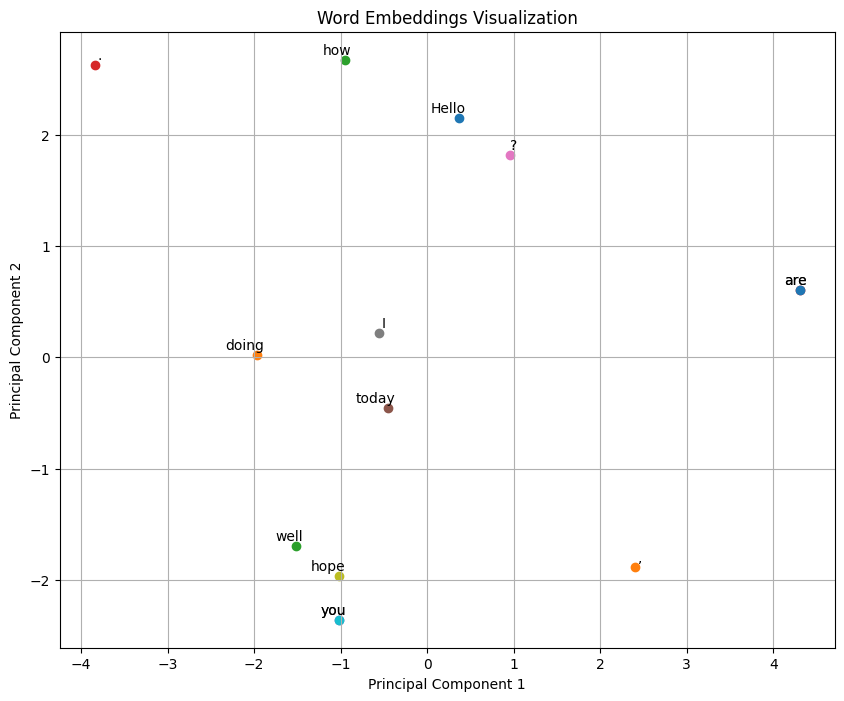


词相似度分析:
 'Hello' 和 ',' 的相似度: 0.2007
 'Hello' 和 'how' 的相似度: 0.0723
 'Hello' 和 'are' 的相似度: 0.0562
 'Hello' 和 'you' 的相似度: -0.6922
 ',' 和 'Hello' 的相似度: 0.2007
 ',' 和 'how' 的相似度: -0.7015
 ',' 和 'are' 的相似度: 0.3779
 ',' 和 'you' 的相似度: 0.0731
 'how' 和 'Hello' 的相似度: 0.0723
 'how' 和 ',' 的相似度: -0.7015
 'how' 和 'are' 的相似度: -0.0756
 'how' 和 'you' 的相似度: -0.2282
 'are' 和 'Hello' 的相似度: 0.0562
 'are' 和 ',' 的相似度: 0.3779
 'are' 和 'how' 的相似度: -0.0756
 'are' 和 'you' 的相似度: -0.3824
 'you' 和 'Hello' 的相似度: -0.6922
 'you' 和 ',' 的相似度: 0.0731
 'you' 和 'how' 的相似度: -0.2282
 'you' 和 'are' 的相似度: -0.3824


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import re

# 示例文本（可自行修改并且测试）
text = "Hello, how are you today? I hope you are doing well."

# 简单分词函数
def tokenize(text):
    # 按非字母数字字符分割文本，并保留分隔符
    tokens = re.findall(r'\w+|[^\w\s]', text)
    return tokens
# 构建词汇表
def build_vocab(tokens):
    unique_tokens = sorted(set(tokens))
    vocab = {token: i for i, token in enumerate(unique_tokens)}
    vocab_size = len(vocab)
    return vocab, vocab_size
# 文本编码
def encode_text(tokens, vocab):
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

# 创建词嵌入模型
class WordEmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(WordEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
    def forward(self, inputs):
        return self.embedding(inputs)

# 可视化词向量
def visualize_embeddings(embeddings, token_ids, vocab):
    reverse_vocab = {i: token for token, i in vocab.items()}
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings.detach().numpy())
    # 绘制散点图
    plt.figure(figsize=(10, 8))
    for i, token_id in enumerate(token_ids):
        plt.scatter(embeddings_2d[i, 0], embeddings_2d[i, 1], marker='o')
        plt.annotate(reverse_vocab[token_id], 
                     (embeddings_2d[i, 0], embeddings_2d[i, 1]),
                     xytext=(5, 2), 
                     textcoords='offset points',
                     ha='right', 
                     va='bottom')
    plt.title('Word Embeddings Visualization')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.grid(True)
    plt.savefig('word_embeddings.png')
    plt.show()

def main():
    tokens = tokenize(text)
    print(f"Tokens: {tokens}")
    tokens_with_special = tokens + ['<pad>', '<unk>']
    
    # 构建词汇表
    vocab, vocab_size = build_vocab(tokens_with_special)
    print(f"Vocabulary size: {vocab_size}")
    print(f"Vocabulary: {vocab}")
    
    # 编码文本
    encoded_text = encode_text(tokens, vocab)
    print(f"Encoded text: {encoded_text}")
    input_tensor = torch.tensor(encoded_text, dtype=torch.long)
    
    # 初始化模型
    embedding_dim = 10  # 词向量维度，即提到的词空间
    model = WordEmbeddingModel(vocab_size, embedding_dim)
    # 获取词向量
    embeddings = model(input_tensor)
    print(f"Embeddings shape: {embeddings.shape}")  # 这里应该是 [序列长度, 嵌入维度]
    
    print(f"Word vector for '{tokens[0]}': {embeddings[0].detach().numpy()}")
    print(f"Word vector for '{tokens[1]}': {embeddings[1].detach().numpy()}")
    # 可视化词向量（仅用于低维演示，实际应用中词向量维度通常较高）
    if embedding_dim >= 2:
        visualize_embeddings(embeddings, encoded_text, vocab)
    
    # 计算词之间的相似度
    print("\n词相似度分析:")
    for i, token_i in enumerate(tokens[:5]):  # 只分析前5个词
        for j, token_j in enumerate(tokens[:5]):
            if i != j:
                # 计算余弦相似度
                sim = F.cosine_similarity(embeddings[i].unsqueeze(0), 
                                         embeddings[j].unsqueeze(0))
                print(f" '{token_i}' 和 '{token_j}' 的相似度: {sim.item():.4f}")

if __name__ == "__main__":
    main()    